In this notebook, we work on Face Keypoint Detection.
To write this article, I refer to the following blog posts.
* [Detecting facial features using Deep Learning](https://towardsdatascience.com/detecting-facial-features-using-deep-learning-2e23c8660a7a)
* [A Convolutional Neural Network for Face Keypoint Detection](http://flothesof.github.io/convnet-face-keypoint-detection.html)

In [52]:
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib  inline

In [53]:
df = pd.read_csv("datasets/training.csv")

In [54]:
df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [55]:
df.shape

(7049, 31)

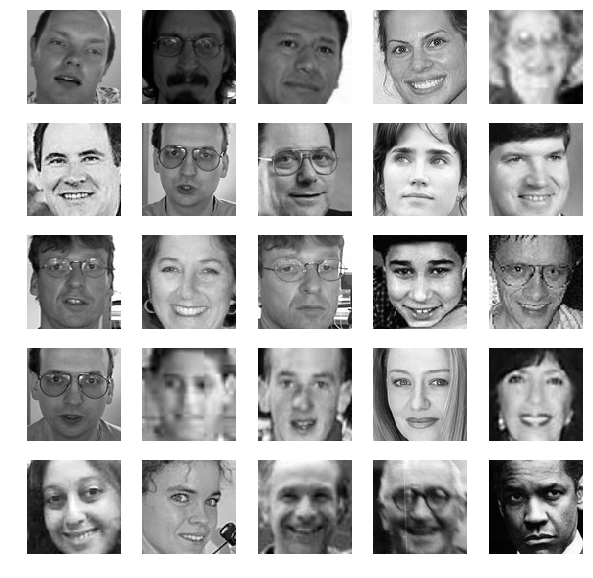

In [56]:
def string2image(string):
    """Converts a string to a numpy array."""
    return np.array([int(item) for item in string.split()]).reshape((96, 96))

def plot_faces(nrows=5, ncols=5):
    """Randomly displays some faces from the training data."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_strings = df.loc[selection]['Image']
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for string, ax in zip(image_strings, axes.ravel()):
        ax.imshow(string2image(string), cmap='gray')
        ax.axis('off')

plot_faces()

In [61]:
keypoint_cols = list(df.columns)[:-1]
xy = df.iloc[1][keypoint_cols].values.reshape((-1, 2))
xy

array([[64.3329361702, 34.9700765957],
       [29.949276595700002, 33.4487148936],
       [58.856170212799995, 35.2743489362],
       [70.7227234043, 36.1871659574],
       [36.034723404299996, 34.3615319149],
       [24.472510638299998, 33.1444425532],
       [53.9874042553, 28.2759489362],
       [78.634212766, 30.405923404299998],
       [42.7288510638, 26.1460425532],
       [16.8653617021, 27.058859574499998],
       [48.2062978723, 55.6609361702],
       [56.4214468085, 76.352],
       [35.122382978699996, 76.0476595745],
       [46.684595744700005, 70.2665531915],
       [45.467914893599996, 85.48017021279999]], dtype=object)

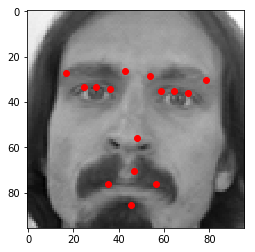

In [63]:
plt.plot(xy[:, 0], xy[:, 1], 'ro')
plt.imshow(string2image(df.iloc[0]['Image']), cmap='gray')

In [65]:
fully_annotated = df.dropna()
fully_annotated.shape

(2140, 31)

In [67]:
X = np.stack([string2image(string) for string in fully_annotated["Image"]])

In [69]:
y = np.vstack(fully_annotated[fully_annotated.columns[:-1]].values)

In [70]:
y.shape

(2140, 30)

In [71]:
from torch.utils.data import Dataset, DataLoader
from  torchvision import transforms, utils

In [44]:
episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [45]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions  = memory.sample(BATCH_SIZE)
    batch  = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                  device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

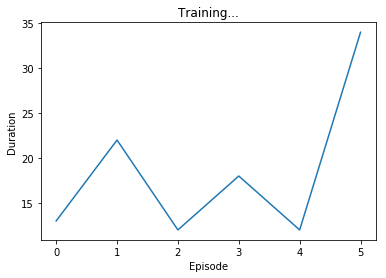

RuntimeError: input and target shapes do not match: input [128 x 1], target [128] at /pytorch/aten/src/THNN/generic/SmoothL1Criterion.c:13

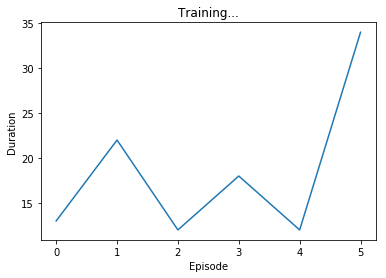

In [46]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

In [31]:
help(torch.Tensor.item)

Help on method_descriptor:

item(...)
    item() -> number
    
    Returns the value of this tensor as a standard Python number. This only works
    for tensors with one element.
    
    This operation is not differentiable.
    
    Example::
    
        >>> x = torch.tensor([1.0])
        >>> x.item()
        1.0



In [17]:
for x, y, z, w in zip(*tests):
    print(x, y, z, w)

1 1 1 1
2 2 2 2
3 3 3 3
4 4 4 4


In [24]:
x = (3, 4, 6, 7)
tests = [x, x, x, x]
list(zip(*tests))

[(3, 3, 3, 3), (4, 4, 4, 4), (6, 6, 6, 6), (7, 7, 7, 7)]

In [60]:
a.argmax(dim=1, keepdim=True)

tensor([[ 1],
        [ 0],
        [ 3],
        [ 0]])

In [18]:
help(T.Compose)

Help on class Compose in module torchvision.transforms.transforms:

class Compose(builtins.object)
 |  Composes several transforms together.
 |  
 |  Args:
 |      transforms (list of ``Transform`` objects): list of transforms to compose.
 |  
 |  Example:
 |      >>> transforms.Compose([
 |      >>>     transforms.CenterCrop(10),
 |      >>>     transforms.ToTensor(),
 |      >>> ])
 |  
 |  Methods defined here:
 |  
 |  __call__(self, img)
 |      Call self as a function.
 |  
 |  __init__(self, transforms)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)

